## Import libraries

In [1]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import training_utils.utils as utils
from training_utils.dataset import CXRNoduleDataset, get_transform
import os
from training_utils.train import train_one_epoch
import torch

## Visualize the dataset

In [2]:
from training_utils.dataset import CXRNoduleDataset
from PIL import ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline
import os

path = 'training_data/'

# use our dataset and defined transformations
dataset = CXRNoduleDataset(path, os.path.join(path,'metadata.csv'), get_transform(train=True))
dataset_test  = CXRNoduleDataset(path, os.path.join(path, 'metadata.csv'), get_transform(train=False))

# Check dataset
dataset.__getitem__(0)

/home/user/.local/lib/python3.6/site-packages/torchvision/transforms/functional.py:132: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0059, 0.0203],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0011, 0.0178],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0011, 0.0180],
          ...,
          [0.0000, 0.4484, 0.4515,  ..., 0.8773, 0.8390, 0.8260],
          [0.0000, 0.4667, 0.4724,  ..., 0.8395, 0.8525, 0.8663],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]),
 {'boxes': tensor([[271., 424., 304., 463.]]),
  'labels': tensor([1]),
  'image_id': tensor([0]),
  'area': tensor([1287.]),
  'iscrowd': tensor([0])},
 '1.png')

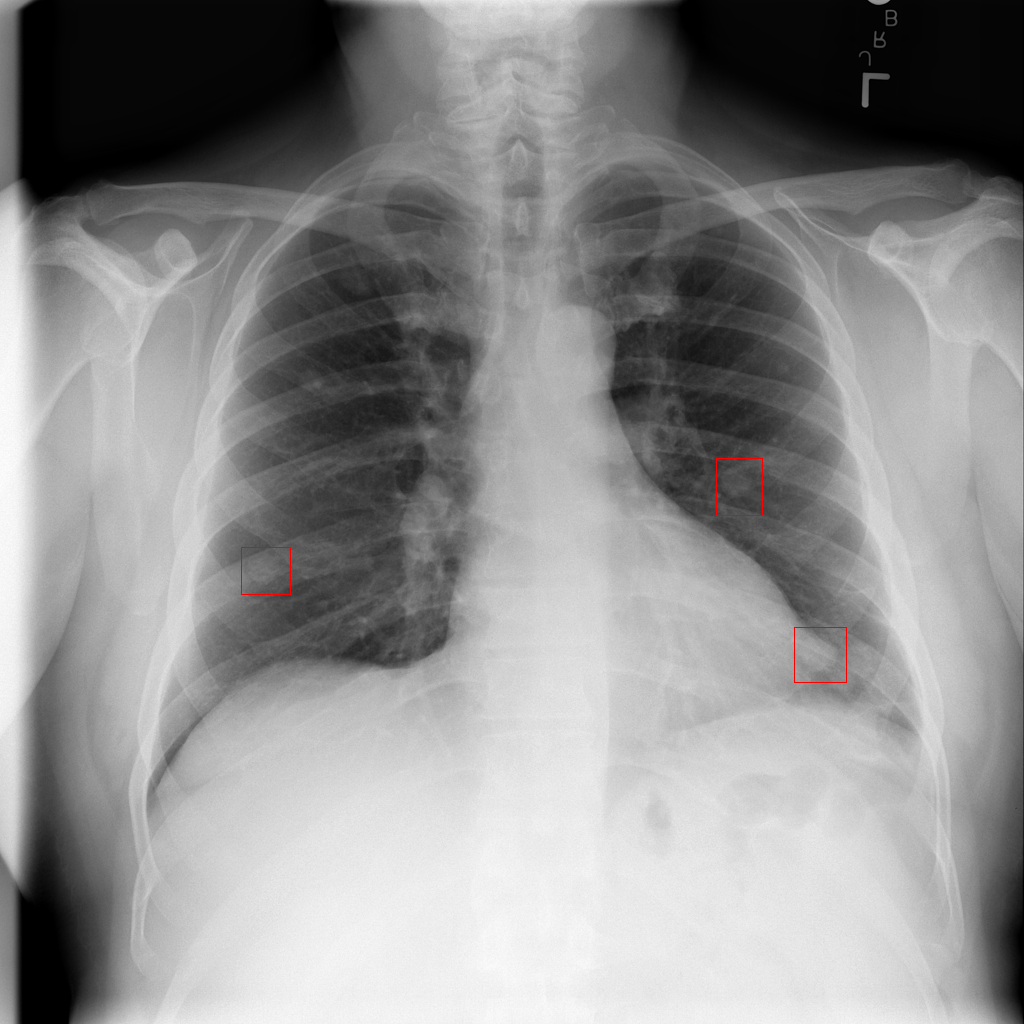

In [3]:
import matplotlib.patches as patches
import numpy as np
from PIL import Image

# an example image from the dataset
idx = 50
img, _ , img_name= dataset_test[idx]
np_img = np.asarray(img)
label_boxes = np.array(dataset_test[idx][1]["boxes"])
image = Image.fromarray(np.tile(img.mul(255).permute(1, 2,0).byte().numpy(), 3))

draw = ImageDraw.Draw(image)
for elem in range(len(label_boxes)):
    draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]), (label_boxes[elem][2], label_boxes[elem][3])], outline ="red")
image



## Define training function

In [4]:
#from engine import train_one_epoch, evaluate
import math

def train(path):
    '''
    path: the root folder containing images folder and metadata.csv
    return:
    returns the trained model
    '''
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    # our dataset has two classes only - background and person
    num_classes = 2
    
    #---------------------- Define dataset ---------------------------------
    # use our dataset and defined transformations
    dataset = CXRNoduleDataset(path, path+'metadata.csv', get_transform(train=True))
    dataset_test  = CXRNoduleDataset(path, path+'metadata.csv', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)
    
    # ----------------------------Define the model ---------------------
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # num_classes which is user-defined
    num_classes = 2  # 1 class (nodule) + background
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 20

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()

    print("That's it!")
    return model
    
    

In [ ]:
# train the model and save
model = train('training_data/')
torch.save(model.state_dict(), "model_v5_20")